# Cuidado! Lluvia de Hamburguesas: 

## Análisis con Naive Bayes


### Integrantes
* Primerano Lomba, Franco Alejandro
* Montecalvo, Ignacio

## Naive Bayes

A continuación realizaremos el analisis con Naive Bayes. Este modelo presenta un sesgo elevado dado a que hace afirmaciones fuertes tales como contemplar a cada uno de los eventos como independientes entre sí para poder hacer el cálculo de la probabilidad condicionada que se utiliza para hacer la clasificación.

Un problema que se nos presenta es que la implementación de Naive Bayes en SkLearn admite sólo variables categoricas (CategoricalNB), o sólo discretas (MultinomialNB), o sólo continuas (GaussianNB). Como tenemos features de varios tipos, una posible solución es calcular las probabilidades por separado segun el tipo de feature y luego hacer un ensamble utilizando GaussianNB.

Como parte del preprocesamiento, vamos a eliminar los missings values (ya importamos el dataset sin missings), luego añadiremos un nuevo feature 'Estacion' para conservar algo de información del feature 'dia' el cual eliminaremos debido a que al ser una fecha puede traer problemas al trabajar con este modelo. Finalmente aplicaremos un filtrado según el tipo de variables: categóricas, discretas o continuas.

El único hiperparametro a definir es:

* alpha/smoothing para CategoricalNB y MultinomialNB / GaussianNB

### Configuraciones iniciales

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
from sklearn.metrics import roc_auc_score, auc, roc_curve, accuracy_score,recall_score, precision_score, f1_score

from preprocessing import agregar_feature_estacion
from preprocessing import obtener_features_continuos, obtener_features_categoricos, obtener_features_discretos
from preprocessing import aplicarOneHot

from auxiliares import obtener_training_set, obtener_valdev_set, obtener_prediccion_set
from auxiliares import plot_confusion_matrix
from auxiliares import plot_roc
from auxiliares import crear_archivo_predicciones

Primero cargamos los datos de entrenamiento con los missings ya tratados.

In [56]:
x,y = obtener_training_set()

### Preprocesamiento

#### Manejo de Missing Values
El manejo de los Missing Values se realiza usando la misma lógica que en la primera parte del TP. De todas formas, ya importamos el dataset de entrenamiento con los missings solucionados

#### Agregado de feature 'Estacion'

In [57]:
x = agregar_feature_estacion(x)

#### Filtrar variables por tipo

In [58]:
x_continuos = x[obtener_features_continuos(x)]
x_categoricos = x[obtener_features_categoricos(x)]
x_discretos = x[obtener_features_discretos(x)]

#### One Hot Encoding
Aplicamos One-hot encoding para las variables categóricas:

In [59]:
x_categoricos = aplicarOneHot(x_categoricos)

### Selección de Hiperparámetros

#### Categorical Naive Bayes

In [60]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=119)
    
cnb_clasificador = CategoricalNB()
gs_cnb = GridSearchCV(cnb_clasificador, {'alpha':[5000,1000,500,100,50,10,1, 0.1, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001]}, n_jobs = -1, cv = kf, scoring ='roc_auc')
gs_cnb.fit(x_categoricos, y.llovieron_hamburguesas_al_dia_siguiente)
    

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=119, shuffle=True),
             estimator=CategoricalNB(), n_jobs=-1,
             param_grid={'alpha': [5000, 1000, 500, 100, 50, 10, 1, 0.1, 0.001,
                                   0.0001, 1e-05, 1e-06, 1e-07]},
             scoring='roc_auc')

In [61]:
resultados = pd.DataFrame(gs_cnb.cv_results_)
resultados = resultados[resultados.rank_test_score <= 5].sort_values(by='rank_test_score', ascending=True)
resultados = resultados[['rank_test_score','param_alpha','mean_test_score','std_test_score','mean_score_time' ]].style.apply(
            lambda x: ['background: lightgreen' if (x.rank_test_score == 1) else '' for i in x], axis=1)
resultados

,rank_test_score,param_alpha,mean_test_score,std_test_score,mean_score_time
2,1,500,0.721872,0.005278,0.188958
3,2,100,0.721708,0.005139,0.193080
4,3,50,0.720747,0.005306,0.285722
5,4,10,0.719456,0.005561,0.231680
6,5,1,0.719054,0.005657,0.154249


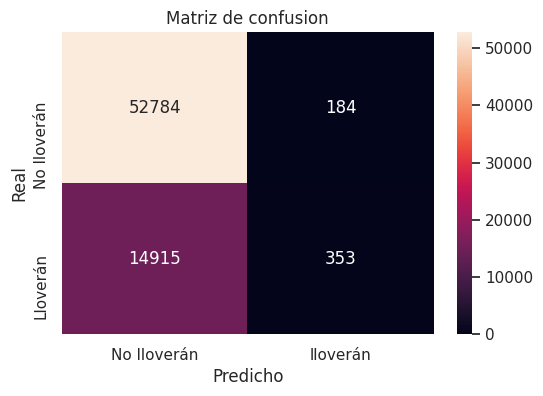

In [62]:
plot_confusion_matrix(y, gs_cnb.best_estimator_.predict(x_categoricos))

Buscamos una primera impresión antes de pasar a la etapa de evaluación. Para el Categorical Naive Bayes, vemos que incluso prediciendo sobre los datos con los que el modelo ya fue entrenado, la predicción hecha es bastante mala y que tiene una fuerte tendencia a predecir que no lloverán hamburguesas al día siguiente.

#### Multinomial Naive Bayes

In [63]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=119)
    
mnb_clasificador = MultinomialNB()
gs_mnb = GridSearchCV(mnb_clasificador, {'alpha':[10000,5000,1000,500,100,50,10,1, 0.1, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001]}, n_jobs = -1, cv = kf, scoring ='roc_auc')
gs_mnb.fit(x_discretos, y.llovieron_hamburguesas_al_dia_siguiente)
    

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=119, shuffle=True),
             estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [10000, 5000, 1000, 500, 100, 50, 10, 1, 0.1,
                                   0.001, 0.0001, 1e-05, 1e-06, 1e-07]},
             scoring='roc_auc')

In [64]:
resultados = pd.DataFrame(gs_mnb.cv_results_)
resultados = resultados[resultados.rank_test_score <= 5].sort_values(by='rank_test_score', ascending=True)
resultados = resultados[['rank_test_score','param_alpha','mean_test_score','std_test_score','mean_score_time' ]].style.apply(
            lambda x: ['background: lightgreen' if (x.rank_test_score == 1) else '' for i in x], axis=1)
resultados

,rank_test_score,param_alpha,mean_test_score,std_test_score,mean_score_time
2,1,1000,0.618631,0.008564,0.040836
3,2,500,0.616212,0.008417,0.043763
4,3,100,0.614744,0.008265,0.046622
5,4,50,0.614526,0.008260,0.047482
6,5,10,0.614358,0.008439,0.042529


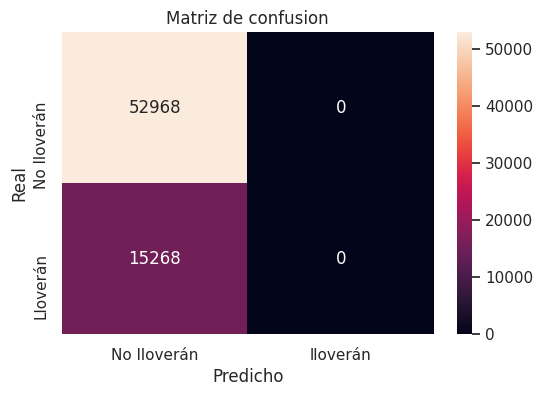

In [65]:
plot_confusion_matrix(y, gs_mnb.best_estimator_.predict(x_discretos))

Para Multinomial Naive Bayes vemos que directamente siempre se predice que no van a llover hamburguesas al día siguiente.

#### Gaussian Naive Bayes

In [66]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=119)
    
gnb_clasificador = GaussianNB()
gs_gnb = GridSearchCV(gnb_clasificador, {'var_smoothing':[1000,500,100,50,10,1, 0.1, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001,0.00000001,0.0000000001,0.00000000001]}, n_jobs = -1, cv = kf, scoring ='roc_auc')
gs_gnb.fit(x_continuos, y.llovieron_hamburguesas_al_dia_siguiente)
    

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=119, shuffle=True),
             estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1000, 500, 100, 50, 10, 1, 0.1,
                                           0.001, 0.0001, 1e-05, 1e-06, 1e-07,
                                           1e-08, 1e-10, 1e-11]},
             scoring='roc_auc')

In [67]:
resultados = pd.DataFrame(gs_gnb.cv_results_)
resultados = resultados[resultados.rank_test_score <= 5].sort_values(by='rank_test_score', ascending=True)
resultados = resultados[['rank_test_score','param_var_smoothing','mean_test_score','std_test_score','mean_score_time' ]].style.apply(
            lambda x: ['background: lightgreen' if (x.rank_test_score == 1) else '' for i in x], axis=1)
resultados

,rank_test_score,param_var_smoothing,mean_test_score,std_test_score,mean_score_time
6,1,0.100000,0.830944,0.004479,0.068314
7,2,0.001000,0.829196,0.004955,0.062415
8,3,0.000100,0.828995,0.004995,0.064285
9,4,0.000010,0.828973,0.004999,0.050781
10,5,0.000001,0.828971,0.004999,0.046872


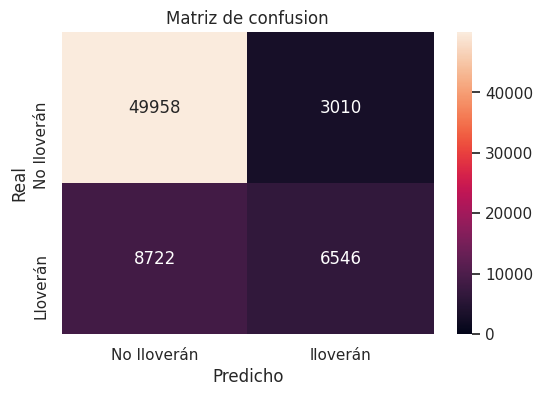

In [68]:
plot_confusion_matrix(y, gs_gnb.best_estimator_.fit(x_continuos,y.llovieron_hamburguesas_al_dia_siguiente).predict(x_continuos))

Para Gaussian Naive Bayes notamos una pequeña mejora. Sin embargo, a nivel general las predicciones no son muy buenas si tenemos en cuenta métricas como Precision, Recall y F1 score.  
  
Además, parecería que nuestros modelos no están teniendo la capacidad de "aprender" y generalizar debido a que predice con alta frecuencia que no lloverán hamburguesas al día siguiente. Creemos que esto puede deberse al desbalance que hay en el dataset entre las dos clases posibles del target, donde predomina fuertemente 'No'. Procedemos a hacer el ensamble y evaluar en el set de validación.

### Ensamble y evaluación del modelo

Cargamos el set de evaluación con los missings ya tratados:

In [69]:
x_val, y_val = obtener_valdev_set()

Aplicamos preprocesamiento al set de validación

In [70]:
# Agregamos feature de estacion
x_val = agregar_feature_estacion(x_val)

# Filtramos por tipo de features
x_continuos_val = x_val[obtener_features_continuos(x_val)]
x_categoricos_val = x_val[obtener_features_categoricos(x_val)]
x_discretos_val = x_val[obtener_features_discretos(x_val)]

# Aplicamos One Hot Encoding a features categoricas
x_categoricos_val = aplicarOneHot(x_categoricos_val)

#### Predicciones usando features categoricos

In [71]:
cnb_clf = gs_cnb.best_estimator_.fit(x_categoricos, y.llovieron_hamburguesas_al_dia_siguiente)

probabilidades_cnb = cnb_clf.predict_proba(x_categoricos)
probabilidades_cnb_x_val = cnb_clf.predict_proba(x_categoricos_val)

#### Predicciones usando features discretos

In [72]:
mnb_clf = gs_mnb.best_estimator_.fit(x_discretos, y.llovieron_hamburguesas_al_dia_siguiente)

probabilidades_mnb = mnb_clf.predict_proba(x_discretos)
probabilidades_mnb_x_val = mnb_clf.predict_proba(x_discretos_val)

#### Predicciones usando features continuos

In [73]:
gnb_clf = gs_gnb.best_estimator_.fit(x_continuos, y.llovieron_hamburguesas_al_dia_siguiente)

probabilidades_gnb = gnb_clf.predict_proba(x_continuos)
probabilidades_gnb_x_val = gnb_clf.predict_proba(x_continuos_val)

Unimos las predicciones (con probabilidad) en un vector

In [74]:
probabilidades_x_train = np.hstack((probabilidades_cnb[:,1].reshape((68236,1)), probabilidades_mnb[:,1].reshape((68236,1)) , probabilidades_gnb[:,1].reshape((68236,1))))
probabilidades_x_test = np.hstack((probabilidades_cnb_x_val[:,1].reshape((28431,1)), probabilidades_mnb_x_val[:,1].reshape((28431,1)) , probabilidades_gnb_x_val[:,1].reshape((28431,1))))

Buscamos mejor hiperparámetro para el ensamble

In [75]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=119)
    
gnb_clasificador = GaussianNB()
gs_gnb_ensamble = GridSearchCV(gnb_clasificador, {'var_smoothing':[5000,1000,500,100,50,10,1, 0.1, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001,0.00000001,0.0000000001,0.00000000001]}, n_jobs = -1, cv = kf, scoring ='roc_auc')
gs_gnb_ensamble.fit(probabilidades_x_train, y.llovieron_hamburguesas_al_dia_siguiente)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=119, shuffle=True),
             estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [5000, 1000, 500, 100, 50, 10, 1, 0.1,
                                           0.001, 0.0001, 1e-05, 1e-06, 1e-07,
                                           1e-08, 1e-10, 1e-11]},
             scoring='roc_auc')

In [76]:
resultados = pd.DataFrame(gs_gnb_ensamble.cv_results_)
resultados = resultados[resultados.rank_test_score <= 5].sort_values(by='rank_test_score', ascending=True)
resultados = resultados[['rank_test_score','param_var_smoothing','mean_test_score','std_test_score','mean_score_time' ]].style.apply(
            lambda x: ['background: lightgreen' if (x.rank_test_score == 1) else '' for i in x], axis=1)
resultados

,rank_test_score,param_var_smoothing,mean_test_score,std_test_score,mean_score_time
5,1,10,0.835019,0.003670,0.041245
4,2,50,0.834983,0.003725,0.049378
3,3,100,0.834973,0.003730,0.044544
2,4,500,0.834966,0.003736,0.044127
1,5,1000,0.834965,0.003736,0.073800


In [77]:
ensamble_nb_clf = gs_gnb_ensamble.best_estimator_
ensamble_nb_clf.fit(probabilidades_x_train,y.llovieron_hamburguesas_al_dia_siguiente)

GaussianNB(var_smoothing=10)

#### Predicciones finales

In [78]:
predicciones = ensamble_nb_clf.predict(probabilidades_x_test)
predicciones_proba = ensamble_nb_clf.predict_proba(probabilidades_x_test)

### Scores

#### AUC ROC



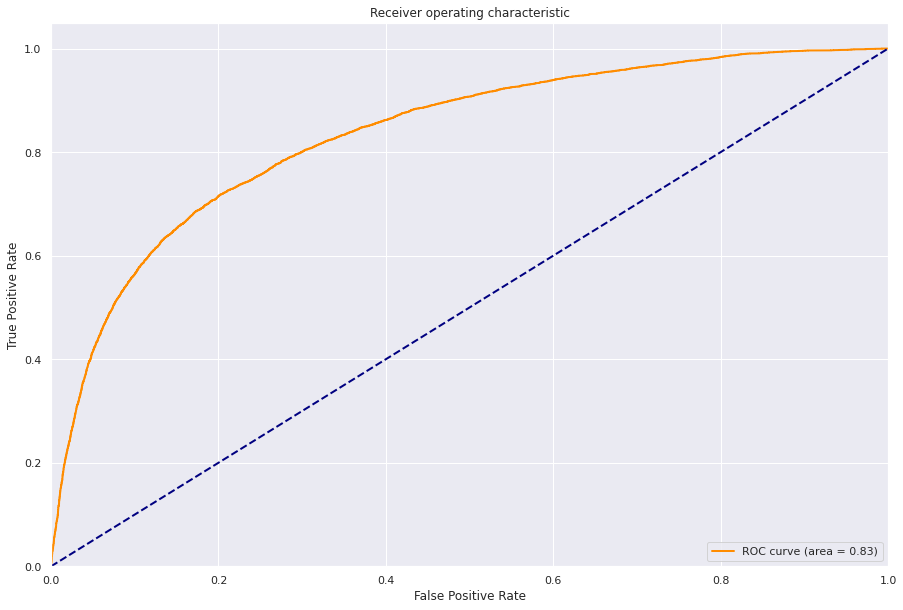

AUC ROC SCORE:  0.8339722822688277


In [79]:
fpr, tpr, thresholds = roc_curve(y_val, predicciones_proba[:, 1], pos_label="si")
plot_roc(fpr, tpr, thresholds)
auc = roc_auc_score(y_val, predicciones_proba[:, 1])
print("AUC ROC SCORE: ",auc)

#### Matriz de confusión



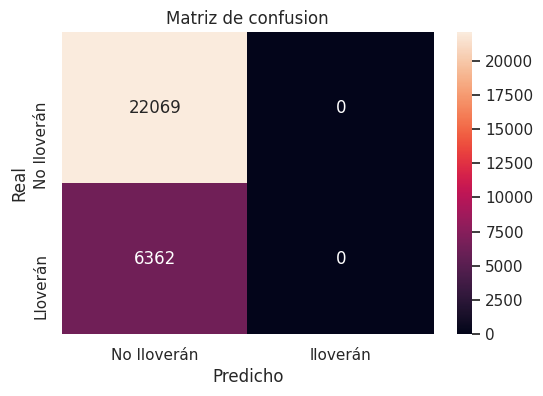

In [80]:
plot_confusion_matrix(y_val, predicciones)

#### Accuracy

In [81]:
accuracy = accuracy_score(y_val,predicciones)
print("ACCURACY SCORE: ",accuracy)

ACCURACY SCORE:  0.7762301712918996


#### Precision y Recall 



In [82]:
precision = precision_score(y_val.llovieron_hamburguesas_al_dia_siguiente,predicciones, pos_label='si')
recall = recall_score(y_val.llovieron_hamburguesas_al_dia_siguiente,predicciones, pos_label='si')

print("PRECISION: ",precision,"\nRECALL: ",recall)

/home/nacho/Escritorio/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


PRECISION:  0.0 
RECALL:  0.0


#### F1 Score

In [83]:
f1 = f1_score(y_val, predicciones, pos_label='si')
print("F1 SCORE: ", f1)

F1 SCORE:  0.0


In [85]:
pd.DataFrame(data=[auc, accuracy, precision,recall,f1],
             index= ['AUC ROC','Accuracy','Precision','Recall','F1 Score'],
             columns=['KNN Scores'])

,KNN Scores
AUC ROC,0.833972
Accuracy,0.776230
Precision,0.000000
Recall,0.000000
F1 Score,0.000000


Vemos que las predicciones obtenidas no mejoraron, de hecho luego de hacer el ensamble se predice siempre 'no' por lo que vamos a descartar esta opción y trataremos de mejorar dichas predicciones. Para ello, realizamos una nueva propuesta:

### Nueva propuesta

Ahora simplemente vamos a optar por quedarnos solamente con las features que tomen valores continuos y sobre ese sub set es que entrenaremos y posteriormente aplicaremos Naive Bayes. Esto lo hacemos ya que GaussianNB fue el que mejor funcionó de los tres.

In [86]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=119)
    
gnb_clasificador = GaussianNB()
gs_gnb_nuevo = GridSearchCV(gnb_clasificador, {'var_smoothing':[1000,500,100,50,10,1, 0.1, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001,0.00000001,0.0000000001,0.00000000001]}, n_jobs = -1, cv = kf, scoring ='roc_auc')
gs_gnb_nuevo.fit(x_continuos, y.llovieron_hamburguesas_al_dia_siguiente)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=119, shuffle=True),
             estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1000, 500, 100, 50, 10, 1, 0.1,
                                           0.001, 0.0001, 1e-05, 1e-06, 1e-07,
                                           1e-08, 1e-10, 1e-11]},
             scoring='roc_auc')

In [87]:
resultados = pd.DataFrame(gs_gnb_nuevo.cv_results_)
resultados = resultados[resultados.rank_test_score <= 5].sort_values(by='rank_test_score', ascending=True)
resultados = resultados[['rank_test_score','param_var_smoothing','mean_test_score','mean_score_time' ]].style.apply(
            lambda x: ['background: lightgreen' if (x.rank_test_score == 1) else '' for i in x], axis=1)
resultados

,rank_test_score,param_var_smoothing,mean_test_score,mean_score_time
6,1,0.100000,0.830944,0.048627
7,2,0.001000,0.829196,0.069539
8,3,0.000100,0.828995,0.066187
9,4,0.000010,0.828973,0.049939
10,5,0.000001,0.828971,0.046147


In [88]:
gnb_clasificador = gs_gnb_nuevo.best_estimator_

In [89]:
gnb_clasificador.fit(x_continuos,y.llovieron_hamburguesas_al_dia_siguiente)

GaussianNB(var_smoothing=0.1)

In [90]:
predicciones = gnb_clasificador.predict(x_val[obtener_features_continuos(x_val)])
predicciones_proba = gnb_clasificador.predict_proba(x_val[obtener_features_continuos(x_val)])

### Scores

#### AUC ROC

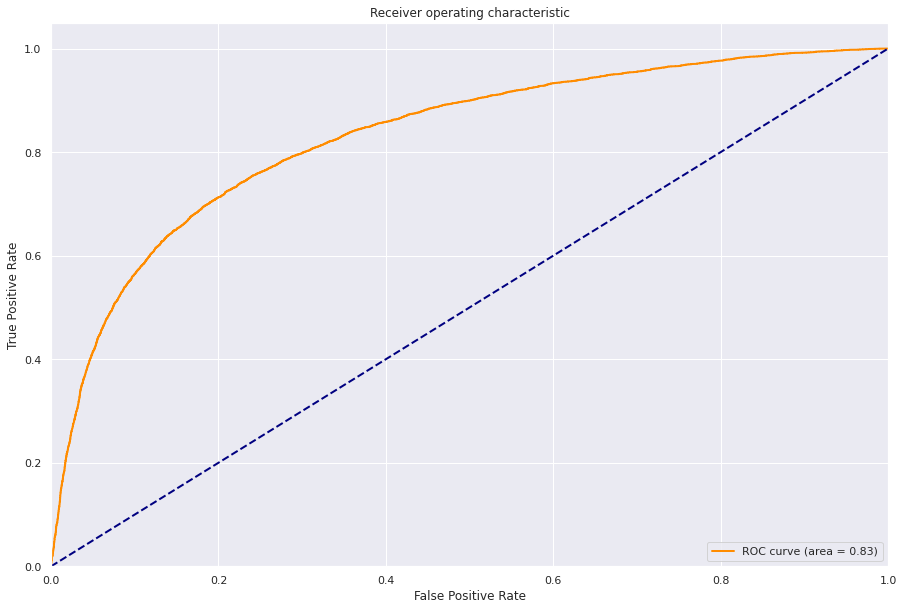

AUC ROC SCORE:  0.8301378265637641


In [92]:
fpr, tpr, thresholds = roc_curve(y_val, predicciones_proba[:, 1], pos_label="si")
plot_roc(fpr, tpr, thresholds)
auc = roc_auc_score(y_val, predicciones_proba[:, 1])
print("AUC ROC SCORE: ",auc)

#### Matriz de confusión



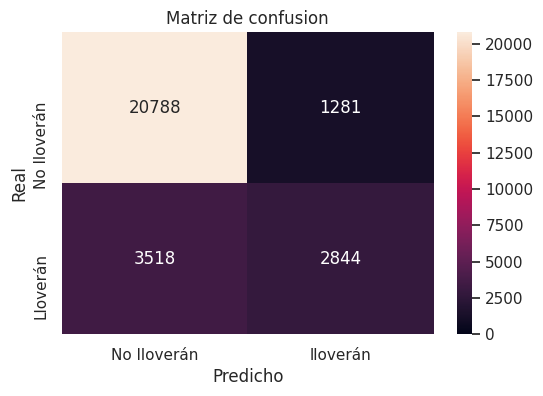

In [93]:
plot_confusion_matrix(y_val, predicciones)

#### Accuracy

In [94]:
accuracy = accuracy_score(y_val,predicciones)
print("ACCURACY SCORE: ",accuracy)

ACCURACY SCORE:  0.831205374415251


#### Precision y Recall 



In [95]:
precision = precision_score(y_val.llovieron_hamburguesas_al_dia_siguiente,predicciones, pos_label='si')
recall = recall_score(y_val.llovieron_hamburguesas_al_dia_siguiente,predicciones, pos_label='si')

print("PRECISION: ",precision,"\nRECALL: ",recall)

PRECISION:  0.6894545454545454 
RECALL:  0.4470292360892801


#### F1 Score

In [96]:
f1 = f1_score(y_val, predicciones, pos_label='si')
print("F1 SCORE: ", f1)

F1 SCORE:  0.5423858110041002


In [97]:
pd.DataFrame(data=[auc, accuracy, precision,recall, f1],
             index= ['AUC ROC','Accuracy','Precision','Recall','F1 Score'],
             columns=['KNN Scores'])

,KNN Scores
AUC ROC,0.830138
Accuracy,0.831205
Precision,0.689455
Recall,0.447029
F1 Score,0.542386


#### Algunas observaciones

* El AUC ROC se mantiene similar al obtenido mediante el ensamble

* El Accuracy mejoró pasando de 0.776 a 0.827

* Sin embargo, la gran mejora está en Precision y Recall (y por lo tanto en F1 Score) debido a que antes daba cero, pues siempre predecia que 'no'. Los score actuales si bien siguen siendo bastante bajos, son mucho mejores a los del ensamble. 

## Predicción sobre el nuevo dataset

Realizamos la predicción sobre el nuevo dataset utilizando el preprocesamiento aplicado anteriormente

In [98]:
nuevo_ds = obtener_prediccion_set()
ids_registro = np.array(nuevo_ds['id'])
nuevo_ds.drop('id', inplace=True, axis=1)

# Relleno de missing values -> Dataset cargado con missing values ya tratados

# Agregamos feature de estacion
nuevo_ds = agregar_feature_estacion(nuevo_ds)

# Filtramos por tipo de features
x_nuevo_continuos = nuevo_ds[obtener_features_continuos(nuevo_ds)]

predicciones = gnb_clasificador.predict(x_nuevo_continuos)
crear_archivo_predicciones(predicciones,"Naive Bayes",ids_registro)